In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['font.size'] = 12

In [5]:
from src import data,viz

In [6]:
import os

In [7]:
df_cosmo_de = data.load_raw_cosmo_de(f'{data.data_root}/external/COSMO/INSERM_datapool_cleaned rawdata_COSMO_Wave 01 to 13.sav')


df_cosmo_de['TIME'] = pd.to_datetime(
    df_cosmo_de.replace(
        {'TIME':dict(zip(range(1,len(data.cosmo_dates['germany'])+1),data.cosmo_dates['germany']))}
    )['TIME']
).astype('datetime64[D]')

df_aff = df_cosmo_de.filter(
    regex='^TIME|^AFF_FEAR|^AFF_THINK|^AFF_WORRY',
    axis=1
).groupby(
    'TIME'
).mean()

In [8]:
import scipy.io as sio
import datetime

In [9]:
df_cosmo_dk = data.load_raw_cosmo_dk(f"{data.data_root}/external/COSMO_dk/COSMO_DK_crossSectional.mat")
df_cosmo_dk['TIME'] = pd.to_datetime(
    df_cosmo_dk.replace(
        {'TIME':dict(zip(range(13,len(data.cosmo_dates['denmark'])+13),data.cosmo_dates['denmark']))}
    )['TIME']
).astype('datetime64[D]')


df_aff_dk = df_cosmo_dk.filter(
    regex='^TIME|^AFF_FEAR|^AFF_THINK|^AFF_WORRY',
    axis=1
).groupby(
    'TIME'
).mean()


In [10]:
aff = {
    'germany': df_aff,
    'denmark': df_aff_dk
}

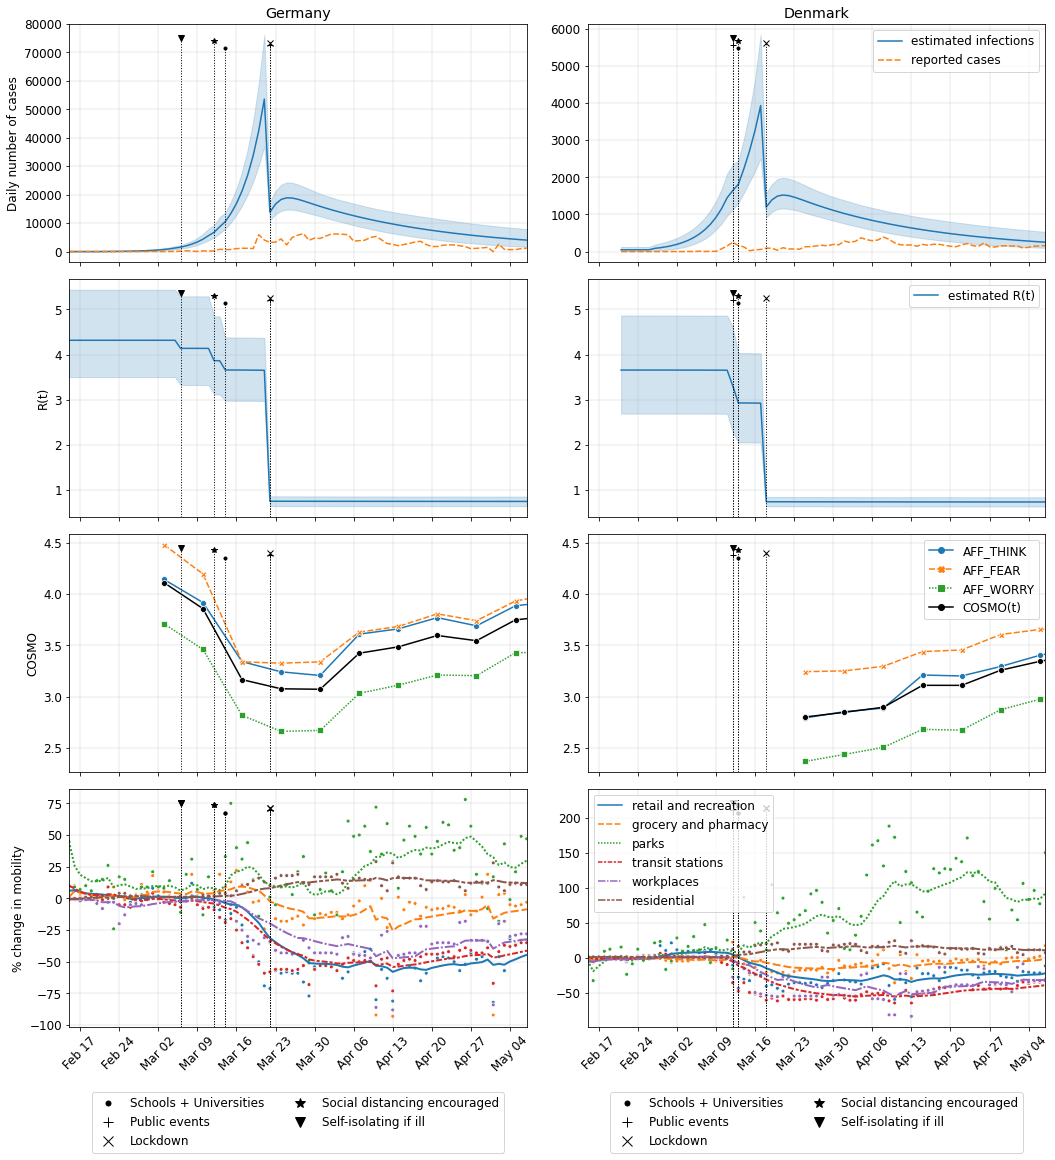

In [11]:
start_date=datetime.date(2020, 2, 15)
end_date=datetime.date(2020,3,1) + datetime.timedelta(days=67)
nrows=4
countries=['germany', 'denmark']
ncols=len(countries)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,nrows*4), sharex=True)

for i, country in enumerate(countries):
    rows=iter(range(nrows))
    
    df = data.load_imperial_college_results(country)
    ax = axs[next(rows),i]
    sns.lineplot(
        data=df[ 
            [ 'predicted_infections_mean', 'reported_cases' ] 
        ].rename(
            axis='columns',
            mapper={
                'predicted_infections_mean': 'estimated infections',
                'reported_cases':  'reported cases'
            }
        ),
        legend='brief' if i==1 else False,
        ax=ax
    )
    ax.fill_between(
        df.index.values,
        df['predicted_infections_lower_CI_95'], 
        df['predicted_infections_higher_CI_95'], 
        color=sns.color_palette()[0],
        alpha=0.2
    )
    if i==0:
        ax.set_ylabel('Daily number of cases')
    ax.set_title(f'{country.capitalize()}')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)

    
    r=next(rows)
    ax=axs[r,i]
    ax.get_shared_y_axes().join(*axs[r,:])
    sns.lineplot(
        data=df[
            ['mean_time_varying_reproduction_number_R(t)']
        ].rename(
            axis='columns',
            mapper={
                'mean_time_varying_reproduction_number_R(t)': 'estimated R(t)',
            }
        ),
        legend='brief' if i==1 else False,
        ax=ax
    )
    ax.fill_between(
        df.index.values,
        df['time_varying_reproduction_number_R(t)_lower_CI_95'],
        df['time_varying_reproduction_number_R(t)_higher_CI_95'],
        color=sns.color_palette()[0],
        alpha=0.2
    )
    if i==0:
        ax.set_ylabel(f'R(t)')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)
    
    r=next(rows)
    ax=axs[r,i]
    ax.get_shared_y_axes().join(*axs[r,:])
    sns.lineplot(
        data=aff[country],
        dashes=True,
        markers=True,
        legend='brief' if i==1 else False,
        ax=ax
    )
    
    sns.lineplot(
        data=aff[country].mean(axis=1).to_frame(name='COSMO(t)'),
        markers=True,
        palette=['k'],
        legend='brief' if i==1 else False,
        ax=ax
    )
    ax.plot()
    if i==0:
        ax.set_ylabel('COSMO')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)
    
    ax=axs[next(rows),i]
    df = data.load_mobility(country, 'google')
    sns.scatterplot(
        data=df,
        legend=False,
        markers=['o']*df.shape[1],
        s=15,
        ax=ax
    )
    sns.lineplot(
        data=df.ewm(com=7).mean().rename(
            axis='columns',
            mapper={
                'retail_and_recreation_percent_change_from_baseline':'retail and recreation',
                'grocery_and_pharmacy_percent_change_from_baseline':'grocery and pharmacy',
                'parks_percent_change_from_baseline':'parks',
                'transit_stations_percent_change_from_baseline':'transit stations',
                'workplaces_percent_change_from_baseline':'workplaces',
                'residential_percent_change_from_baseline':'residential'
            }
        ),
        lw=2,                
        legend='brief' if i==1 else False,
        ax=ax
        
    )
    if i==0:
        ax.set_ylabel('% change in mobility')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)
    

    viz.annotate_interventions(ax,country,legend=True, bbox_offset=-0.4)
    ax.set_xlim(left=start_date, right=end_date)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel('')
fig.tight_layout()
#fig.savefig('fig2.pdf', format='pdf', bbox_inches='tight')